In [1]:
%load_ext autoreload
%autoreload 2
from dark_matters.input import readInputFile

Next I will read in the calculation data for the Coma cluster

In [2]:
dataSets = readInputFile("coma.json",inMode="json")
print(dataSets)

{'haloData': {'haloName': 'coma', 'haloProfile': 'nfw', 'haloScale': 0.287, 'haloCvir': 9.4, 'haloRvir': 2.7, 'haloMvir': 1200000000000000.0, 'haloZ': 0.0231}, 'magData': {'magProfile': 'beta', 'magNorm': 4.7, 'magIndex': -0.327, 'magScale': 0.253, 'magFuncLock': False}, 'gasData': {'gasProfile': 'beta', 'gasNorm': 0.00349, 'gasScale': 0.253, 'gasIndex': -0.654}, 'diffData': {'lossOnly': False, 'diffConstant': 1e+29, 'diffIndex': 1.66666666}, 'partData': {'partModel': 'bb', 'emModel': 'annihilation'}, 'calcData': {'calcMode': 'sb', 'freqMode': 'radio', 'mWIMP': array([  10.,  100., 1000.]), 'fSampleLimits': array([   100., 100000.]), 'fSampleNum': 40, 'fSampleSpacing': 'log', 'adiMaxSteps': 20, 'rSampleNumber': 50, 'eSampleNumber': 50, 'log10RSampleMinFactor': -3, 'electronMode': 'adi-python'}, 'cosmoData': {}}


The dictionary above contains all the entries for the Coma environment and calculation I want to run, namely: haloData, magData, and gasData, diffData, partData, calcData, and cosmoData.
These describe the halo, magnetic field, gas distribution, diffusive environment, particle physics, calculations to run, and cosmology parameters respectively. cosmoData can be left empty and Planck 2019 results will be used by default.

All I need to do is call the runCalculation routine, note that it takes in all the dictionaries and returns them all in a meta dictionary. (On windows you might get warnings about overflow in sparsity calculations, you can ignore these).

In [3]:
from dark_matters.calculations import runCalculation

outputData = runCalculation(**dataSets)

Beginning DarkMatters calculations
Frequency mode: radio
Calculation type: sb
Run Parameters
Frequency Samples: 40
Minimum Frequency Sampled: 1.00e+02 MHz 
Maximum Frequency Sampled: 1.00e+05 MHz
Radial Grid Intervals: 80
Minimum Sampled Radius: 2.870e-04 Mpc
Maximum Sampled Radius: 5.400e+00 Mpc
Halo Parameters: 
Halo Name: coma
Redshift z: 2.31e-02
Luminosity Distance: 104.031 Mpc
Halo profile: nfw
Virial Mass: 1.200e+15 Solar Masses
Virial Radius: 2.700e+00 Mpc
Halo scale radius: 2.870e-01 Mpc
Rho_s/Rho_crit: 2.157e+04
Virial Concentration: 9.40
Gas Parameters: 
Gas density profile: beta
gasScale: 0.253 Mpc 
gasIndex: -0.654
gasNorm: 0.00349 cm^-3 
Magnetic Field Parameters: 
Magnetic field profile: beta
magNorm: 4.7 micro-Gauss 
magScale: 0.253 Mpc 
magIndex: -0.327
Spatial Diffusion
Turbulence index: 1.67
Diffusion constant: 1.00e+29 cm^2 s^-1
Now calculating for Dark Matter model: 
WIMP mass: 10.0 GeV
Particle physics: bb
Emission type: annihilation
Calculating Electron Equilibri

You might think that took a while to run but note we did 120 separate computations (3 WIMP masses and 40 frequency bins!) Some parameter tuning can be done for optimization (see Wiki).

Now I can store the output, I will do so using the yaml format. The code assigns a name automatically, if I specify the `tag` argument, an additional tag (the value of tag) will be added.

In [4]:
from dark_matters.output import makeOutput

makeOutput(**outputData,outMode="yaml")

Now I will plot some of the output. Here I will choose one frequency and plot the surface brightness vs angular radius. For surface brightness, `calcData['results']['finalData']` has one array per entry in `calcData['mWIMP']`, each array is `calcData['fSampleNum']` by `calcData['rSampleNum']`. I can see the values using `calcData['fSampleValues']` and `calcData['angSampleValues']` for angular radii (when finding surface brightness only).

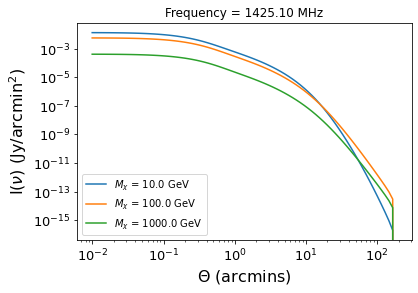

In [5]:
from matplotlib import pyplot as plt
import numpy as np 
freqIndex = (np.abs(outputData['calcData']['fSampleValues'] - 1400)).argmin() #Nearest frequency to 1400 MHz

for i in range(len(outputData['calcData']['mWIMP'])):
    plt.plot(outputData['calcData']['angSampleValues'],outputData['calcData']['results']['finalData'][i][freqIndex],label=r"$M_\chi$ = "+str(outputData['calcData']['mWIMP'][i])+" GeV")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"I$(\nu)$ (Jy/arcmin$^2$)",fontsize=16)
plt.xlabel(r"$\Theta$ (arcmins)",fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(f"Frequency = {outputData['calcData']['fSampleValues'][freqIndex]:.2f} MHz")
plt.legend()
plt.show()

Finally, I can produce a fits map for use if I need to compare to observations (by default the cross-section used here is $10^{-26}$ cm $^3$ s $^{-1}$ but the sigV argument can control this). Note I need to specify the location of the target centre in the form of an astropy SkyCoord object to do this. I have it calculated for 3 frequencies, 900 MHz, 1 GHz, and 1.1 GHz. By specifying display_slice = 0 I get the 900 MHz plot appearing. I can use `targetResolution` (in arcmin) to control the pixel size and `rMax` to determine the maximum radius I want to use (in Mpc). Note that if you make `targetResolution` too small the parameter `maxPix` will kick and limit resolution to prevent your kernel crashing. All the data is written to a fits file

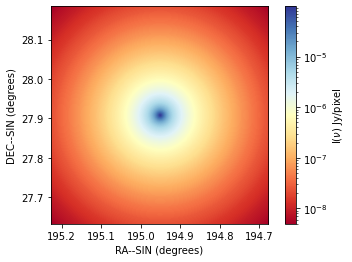

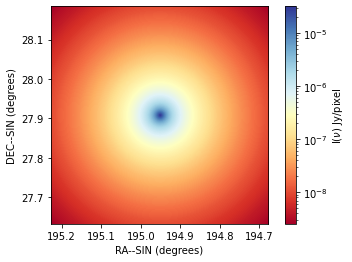

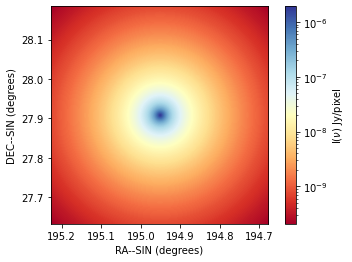

In [13]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from dark_matters.output import fitsMap

c = SkyCoord(ra="12h59m48.7s", dec=+27.9086, frame='icrs',unit=(u.hourangle, u.deg))
fitsMap(c,[0.9e3,1.0e3,1.1e3],outputData['calcData'],outputData['haloData'],outputData['partData'],outputData['diffData'],display_slice=0,sigV=1e-26,targetResolution=3/60,rMax=0.5) 